<a href="https://colab.research.google.com/github/GeorgeSherif/NLP-ChatEGP/blob/main/Model%20With%20Data%20Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing & Importing the Necessary Libraries and Mounting the drive**

In [1]:
!pip3 install transformers sentencepiece protobuf torch pygal torchvision sacremoses


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 40.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.7 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895241 sha256=b74b4bccffb5545dfcbddf2eaaf7a4ade44781276c73c55771bd2bc7435c6483
  Stored in directory: /root/.cache/pip/wheels/00/24/97/a2ea5324f36bc626e1ea0267f33db6aa80d157ee977e9e42fb
Successfully built sacremoses


In [2]:
from google.colab import drive
from IPython.display import display # Allows the use of display() for DataFrames
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [3]:
import pandas as pd
import numpy as np
import os
import warnings
import csv
import re
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
import pygal as py
import matplotlib
plt.rcParams["figure.figsize"] = (8,5)
matplotlib.rc('xtick', labelsize=7) 
matplotlib.rc('ytick', labelsize=7) 

import torch
import torchvision

from sklearn.feature_extraction.text import CountVectorizer

warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline 

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# **Approach 1: Evaluate the English Model (BERT)**


*   English Train Data
*   Arabic Test Data
*   Train with the English Dataset
*   Translate the Arabic Dataset
*   Evaluate Model





### Load the English Dataset

In [5]:
#df = pd.read_csv('/content/gdrive/MyDrive/NLP/English Dataset.csv' ,engine="python", encoding = "ISO-8859-1")
df = pd.read_csv('/content/gdrive/MyDrive/NLP/Augmented.csv' ,engine="python", encoding = "ISO-8859-1")
print((df['Sentiment'] == 'negative').sum())


1208


In [6]:
num_entries_to_remove_positive = (df['Sentiment'] == 'positive').sum() - (df['Sentiment'] == 'negative').sum()
num_entries_to_remove_neutral = (df['Sentiment'] == 'neutral').sum() - (df['Sentiment'] == 'negative').sum()
print(num_entries_to_remove_neutral)


indices_to_remove = df[df['Sentiment'] == 'positive'].sample(num_entries_to_remove_positive).index
dfPositive = df[df['Sentiment'] == 'positive'].drop(indices_to_remove)

indices_to_remove = df[df['Sentiment'] == 'neutral'].sample(num_entries_to_remove_neutral).index
dfNeutral = df[df['Sentiment'] == 'neutral'].drop(indices_to_remove)

indices_to_remove = df[df['Sentiment'] == 'negative'].sample(0).index
dfNegative = df[df['Sentiment'] == 'negative'].drop(indices_to_remove)

print(dfNegative)

1671
     Sentiment                                           Sentence
2     negative  The international electronic industry company ...
415   negative  A tinyurl link takes users to a scamming site ...
421   negative  Compared with the FTSE 100 index , which rose ...
423   negative  Compared with the FTSE 100 index , which rose ...
500   negative  One of the challenges in the oil production in...
...        ...                                                ...
5445  negative  The cargo handling group posted a surprise dro...
5446  negative  The share prices in London ended lower on Mond...
5447  negative  The operating profit fell from the previous ye...
5448  negative  Net sales of the Paper segment decreased to 22...
5449  negative  In January, sales in Finland decreased by 10% ...

[1208 rows x 2 columns]


In [7]:
dfNew = pd.concat((dfNegative, dfNeutral, dfPositive), axis = 0)
dfNew
df = dfNew

In [8]:
df['Sentiment'] = df['Sentiment'].replace(['negative','neutral','positive'],[0,1,2])
df

,Sentiment,Sentence
2,0,The international electronic industry company ...
415,0,A tinyurl link takes users to a scamming site ...
421,0,"Compared with the FTSE 100 index , which rose ..."
423,0,"Compared with the FTSE 100 index , which rose ..."
500,0,One of the challenges in the oil production in...
...,...,...
4775,2,"The apartment block will be well-located , in ..."
4780,2,"The antibody , given at repeated doses of up t..."
4786,2,Danske Bank A-S DANSKE DC jumped 3.7 percent t...
4787,2,Our superior customer centricity and expertise...


<Axes: xlabel='count', ylabel='Sentiment'>

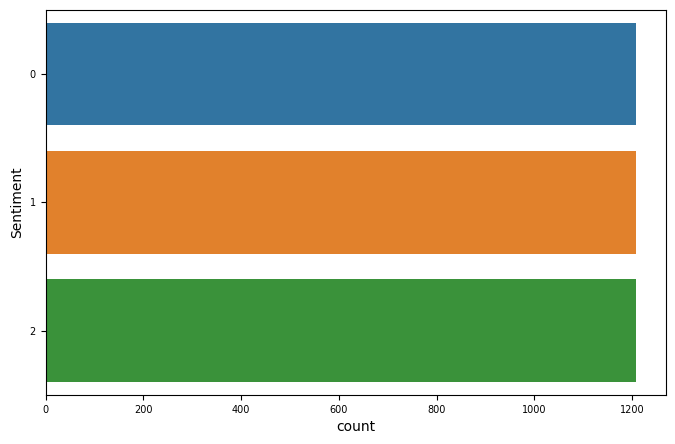

In [9]:
sns.countplot(y="Sentiment",data=df)

In [10]:
df.drop_duplicates(subset=['Sentence'],keep='first',inplace=True)
df

,Sentiment,Sentence
2,0,The international electronic industry company ...
415,0,A tinyurl link takes users to a scamming site ...
421,0,"Compared with the FTSE 100 index , which rose ..."
423,0,"Compared with the FTSE 100 index , which rose ..."
500,0,One of the challenges in the oil production in...
...,...,...
4775,2,"The apartment block will be well-located , in ..."
4780,2,"The antibody , given at repeated doses of up t..."
4786,2,Danske Bank A-S DANSKE DC jumped 3.7 percent t...
4787,2,Our superior customer centricity and expertise...


### Sentiment Analysis using BERT

In [11]:
from sklearn.model_selection import train_test_split
X_features = df["Sentence"]
Y_features = df["Sentiment"]
X_train, X_val, y_train, y_val = train_test_split(df.index.values, df.Sentiment.values, test_size=0.2, random_state=42, shuffle=True)

In [12]:
from transformers import BertTokenizer,BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = 3,
                                                      id2label={0: 'negative', 1: 'neutral', 2: 'positive'},
                                                      output_attentions = False,
                                                      output_hidden_states = False).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [13]:
df['data_type'] = ['not_set'] * df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

#groupby count
df.groupby([ 'Sentiment', 'data_type']).count()
#df = df.rename(columns={'Review Text': 'Sentence'})
df[df.data_type == 'train'].Sentence.values


array(['A tinyurl link takes users to a scamming site promising that users can earn thousands of dollars by becoming a Google ( NASDAQ : GOOG ) Cash advertiser .',
       'Compared with the FTSE 100 index , which rose 36.7 points ( or 0.6 % ) on the day , this was a relative price change of -0.2 % .',
       'Compared with the FTSE 100 index , which rose 94.9 points ( or 1.6 % ) on the day , this was a relative price change of -0.4 % .',
       ...,
       'The antibody , given at repeated doses of up to 8 mg-kg , was generally well tolerated , and the pharmacokinetic characteristics of BTT-1023 in psoriasis patients were consistent with those observed in a previously completed study in rheumatoid arthritis RA patients .',
       'Our superior customer centricity and expertise in digital services set us apart from our competitors .',
       'The 2015 target for net sales has been set at EUR 1bn and the target for return on investment at over 20 % .'],
      dtype=object)

In [14]:
#encode train set
encoded_data_train = tokenizer.batch_encode_plus(df[df.data_type == 'train'].Sentence.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 150,
                                                truncation=True,
                                                return_tensors = 'pt')
                                                
#encode validation set
encoded_data_val = tokenizer.batch_encode_plus( df[df.data_type == 'val'].Sentence.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 150,
                                                truncation=True,
                                                return_tensors = 'pt')

In [15]:
#train set
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type == 'train'].Sentiment.values)

#validation set
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type == 'val'].Sentiment.values)
     

In [16]:
from torch.utils.data import TensorDataset

#train set
dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)

#validation set
dataset_val = TensorDataset(input_ids_val, 
                             attention_masks_val, 
                             labels_val)

In [17]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 8

#train set
dataloader_train = DataLoader(dataset_train,
                              sampler = RandomSampler(dataset_train),
                              batch_size = batch_size)

#validation set
dataloader_val = DataLoader(dataset_val,
                              sampler = RandomSampler(dataset_val),
                              batch_size = batch_size) #since we don't have to do backpropagation for this step

In [18]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                 lr = 1e-5,
                 eps = 1e-7) #2e-5 > 5e-5
                 
epochs = 16

scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps =len(dataloader_train)*epochs)


In [19]:
def evaluate(dataloader_val):

    #evaluation mode 
    model.eval()
    
    #tracking variables
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        #load into GPU
        batch = tuple(b.to(device) for b in batch)
        
        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #compute logits
        with torch.no_grad():        
            outputs = model(**inputs)
        
        #compute loss
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        #compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    #compute average loss
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [20]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

In [21]:
#accuracy score
def accuracy_per_class(preds, labels):
    #label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    #make prediction
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    correct = 0
    total = 0

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        #print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n -> {len(y_preds[y_preds==label]) / len(y_true)}')
        correct = correct + len(y_preds[y_preds==label])
        total = total + len(y_true)
    return correct / total

In [22]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [23]:
epochs_accuracies = []

In [24]:
from tqdm import tqdm

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, 
                        desc = 'Epoch {:1d}'.format(epoch), 
                        leave = False, 
                        disable = False)
    
    for batch in progress_bar:
        
        model.zero_grad() #set gradient to 0
    
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids': batch[0], 
                  'attention_mask': batch[1], 
                  'labels': batch[2]}
        
        outputs = model(**inputs) #unpack the dict straight into inputs
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
        
    torch.save(model.state_dict(), f'/content/gdrive/MyDrive/NLP/2_Augmented_BERT_ft_epoch{epoch}.model')
    
    tqdm.write('\n Epoch {epoch}')
    
    loss_train_ave = loss_train_total / len(dataloader_train)
    tqdm.write('Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    true_vals.shape
    accuracy = accuracy_per_class(predictions, true_vals)
    epochs_accuracies.append(accuracy)

    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')
    tqdm.write(f'Accuracy Score: {accuracy}')

  0%|          | 0/16 [01:27<?, ?it/s]


 Epoch {epoch}
Training loss: {loss_train_avg}



  6%|▋         | 1/16 [01:34<23:37, 94.48s/it]

Accuracy:239/254
 -> 0.9409448818897638
Accuracy:146/239
 -> 0.6108786610878661
Accuracy:204/231
 -> 0.8831168831168831
Validation loss: 0.46609668732508197
F1 Score (weighted): 0.8079929404926656
Accuracy Score: 0.81353591160221



  6%|▋         | 1/16 [03:02<23:37, 94.48s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 12%|█▎        | 2/16 [03:09<22:06, 94.78s/it]

Accuracy:229/254
 -> 0.9015748031496063
Accuracy:194/239
 -> 0.8117154811715481
Accuracy:196/231
 -> 0.8484848484848485
Validation loss: 0.4048622385547547
F1 Score (weighted): 0.8554331718608541
Accuracy Score: 0.8549723756906077



 12%|█▎        | 2/16 [04:38<22:06, 94.78s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 19%|█▉        | 3/16 [04:45<20:41, 95.50s/it]

Accuracy:240/254
 -> 0.9448818897637795
Accuracy:195/239
 -> 0.8158995815899581
Accuracy:195/231
 -> 0.8441558441558441
Validation loss: 0.516228969513367
F1 Score (weighted): 0.8697768866934764
Accuracy Score: 0.8701657458563536



 19%|█▉        | 3/16 [06:14<20:41, 95.50s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 25%|██▌       | 4/16 [06:21<19:06, 95.55s/it]

Accuracy:246/254
 -> 0.968503937007874
Accuracy:186/239
 -> 0.7782426778242678
Accuracy:193/231
 -> 0.8354978354978355
Validation loss: 0.6934878235148102
F1 Score (weighted): 0.8615713216559242
Accuracy Score: 0.8632596685082873



 25%|██▌       | 4/16 [07:49<19:06, 95.55s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 31%|███▏      | 5/16 [07:56<17:29, 95.40s/it]

Accuracy:243/254
 -> 0.9566929133858267
Accuracy:192/239
 -> 0.803347280334728
Accuracy:199/231
 -> 0.8614718614718615
Validation loss: 0.6959353882498313
F1 Score (weighted): 0.8747816947665534
Accuracy Score: 0.8756906077348067



 31%|███▏      | 5/16 [09:24<17:29, 95.40s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 38%|███▊      | 6/16 [09:31<15:52, 95.25s/it]

Accuracy:241/254
 -> 0.9488188976377953
Accuracy:176/239
 -> 0.7364016736401674
Accuracy:205/231
 -> 0.8874458874458875
Validation loss: 0.8424851069422592
F1 Score (weighted): 0.8576250686577638
Accuracy Score: 0.8591160220994475



 38%|███▊      | 6/16 [11:00<15:52, 95.25s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 44%|████▍     | 7/16 [11:07<14:18, 95.39s/it]

Accuracy:241/254
 -> 0.9488188976377953
Accuracy:177/239
 -> 0.7405857740585774
Accuracy:210/231
 -> 0.9090909090909091
Validation loss: 0.8509011414026135
F1 Score (weighted): 0.8658219625441168
Accuracy Score: 0.8674033149171271



 44%|████▍     | 7/16 [12:36<14:18, 95.39s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 50%|█████     | 8/16 [12:43<12:44, 95.54s/it]

Accuracy:243/254
 -> 0.9566929133858267
Accuracy:178/239
 -> 0.7447698744769874
Accuracy:203/231
 -> 0.8787878787878788
Validation loss: 0.903325861101461
F1 Score (weighted): 0.8601347518919401
Accuracy Score: 0.861878453038674



 50%|█████     | 8/16 [14:11<12:44, 95.54s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 56%|█████▋    | 9/16 [14:18<11:09, 95.64s/it]

Accuracy:237/254
 -> 0.9330708661417323
Accuracy:183/239
 -> 0.7656903765690377
Accuracy:202/231
 -> 0.8744588744588745
Validation loss: 0.9068954322801501
F1 Score (weighted): 0.8586896684472276
Accuracy Score: 0.8591160220994475



 56%|█████▋    | 9/16 [15:51<11:09, 95.64s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 62%|██████▎   | 10/16 [15:58<09:41, 96.86s/it]

Accuracy:244/254
 -> 0.9606299212598425
Accuracy:180/239
 -> 0.7531380753138075
Accuracy:203/231
 -> 0.8787878787878788
Validation loss: 0.9574879238507192
F1 Score (weighted): 0.8643874115560483
Accuracy Score: 0.8660220994475138



 62%|██████▎   | 10/16 [17:27<09:41, 96.86s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 69%|██████▉   | 11/16 [17:34<08:02, 96.53s/it]

Accuracy:243/254
 -> 0.9566929133858267
Accuracy:189/239
 -> 0.7907949790794979
Accuracy:196/231
 -> 0.8484848484848485
Validation loss: 0.9622688768278029
F1 Score (weighted): 0.866309098013523
Accuracy Score: 0.8674033149171271



 69%|██████▉   | 11/16 [19:02<08:02, 96.53s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 75%|███████▌  | 12/16 [19:09<06:24, 96.16s/it]

Accuracy:242/254
 -> 0.952755905511811
Accuracy:173/239
 -> 0.7238493723849372
Accuracy:209/231
 -> 0.9047619047619048
Validation loss: 1.0400756511150107
F1 Score (weighted): 0.8598205359232806
Accuracy Score: 0.861878453038674



 75%|███████▌  | 12/16 [20:37<06:24, 96.16s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 81%|████████▏ | 13/16 [20:44<04:47, 95.89s/it]

Accuracy:243/254
 -> 0.9566929133858267
Accuracy:188/239
 -> 0.7866108786610879
Accuracy:199/231
 -> 0.8614718614718615
Validation loss: 0.9710231017808117
F1 Score (weighted): 0.869013397813167
Accuracy Score: 0.8701657458563536



 81%|████████▏ | 13/16 [22:13<04:47, 95.89s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 88%|████████▊ | 14/16 [22:20<03:11, 95.92s/it]

Accuracy:242/254
 -> 0.952755905511811
Accuracy:172/239
 -> 0.7196652719665272
Accuracy:208/231
 -> 0.9004329004329005
Validation loss: 1.0765007099257122
F1 Score (weighted): 0.8569195586080348
Accuracy Score: 0.8591160220994475



 88%|████████▊ | 14/16 [23:49<03:11, 95.92s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 94%|█████████▍| 15/16 [23:56<01:35, 95.70s/it]

Accuracy:244/254
 -> 0.9606299212598425
Accuracy:178/239
 -> 0.7447698744769874
Accuracy:204/231
 -> 0.8831168831168831
Validation loss: 1.040981506422203
F1 Score (weighted): 0.8627757159124457
Accuracy Score: 0.8646408839779005



 94%|█████████▍| 15/16 [25:24<01:35, 95.70s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



100%|██████████| 16/16 [25:31<00:00, 95.73s/it]

Accuracy:244/254
 -> 0.9606299212598425
Accuracy:174/239
 -> 0.7280334728033473
Accuracy:205/231
 -> 0.8874458874458875
Validation loss: 1.0515044150155377
F1 Score (weighted): 0.8582720373798038
Accuracy Score: 0.8604972375690608


In [25]:
_, predictions, true_vals = evaluate(dataloader_val)

100%|██████████| 91/91 [00:06<00:00, 13.27it/s]


In [26]:
true_vals.shape
accuracy_per_class(predictions, true_vals)

Accuracy:244/254
 -> 0.9606299212598425
Accuracy:174/239
 -> 0.7280334728033473
Accuracy:205/231
 -> 0.8874458874458875


0.8604972375690608

In [27]:
epochs_accuracies
epochs_accuracies2 = []
for i in range(len(epochs_accuracies)):
  epochs_accuracies2.append(float(round(epochs_accuracies[i] * 100, 1)))
epochs_accuracies2

[81.4,
 85.5,
 87.0,
 86.3,
 87.6,
 85.9,
 86.7,
 86.2,
 85.9,
 86.6,
 86.7,
 86.2,
 87.0,
 85.9,
 86.5,
 86.0]